In [ ]:
# MLB 2025 Postseason Pitch Analysis Using Statcast Data  
### By: *Joseph Cornetta*


## Methods Overview

- **Data Source:** Pitch-by-pitch Statcast data from the 2025 MLB postseason, exported as a CSV and loaded into Python using `pandas`.
- **Environment:** Jupyter Notebook with `pandas` for data manipulation and `matplotlib`/`seaborn` for visualization.
- **Key Derived Metrics:**
  - `is_swing` and `is_whiff` flags based on pitch descriptions to calculate whiff rates by pitch type and pitcher.
  - Average pitch velocity and velocity distributions by pitch type to profile arsenals.
  - `is_hard_hit` flag for balls in play with exit velocity ≥ 95 mph to approximate hard-contact rate.
- **Filters & Sample Size Controls:**
  - Whiff rates and hard-hit rates were only calculated on relevant subsets (swing events or balls in play).
  - Minimum sample size thresholds (e.g., ≥ 20 swings for whiff rate, ≥ 30 balls in play for hard-hit rate) were used to avoid misleading results from very small samples.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries loaded")


Libraries loaded


In [3]:
df = pd.read_csv("Data_MLB_2025_StatcastPostseason_PitchByPitch_20251102a.csv")

df.head()


,game_year,game_date,player_name,pitcher,batter,balls,strikes,inning,inning_topbot,at_bat_number,...,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length
0,2025,2025-09-30,"Ashcraft, Graham",668933,605141,0,0,8,Bot,73,...,10,10,5,Standard,Standard,42.0,0.0,0.041,NaN,NaN
1,2025,2025-09-30,"Ashcraft, Graham",668933,605141,1,0,8,Bot,73,...,10,10,5,Standard,Standard,201.0,0.0,-0.050,NaN,NaN
2,2025,2025-09-30,"Ashcraft, Graham",668933,605141,1,1,8,Bot,73,...,10,10,5,Standard,Standard,23.0,0.0,-0.061,65.0,6.0
3,2025,2025-09-30,"Ashcraft, Graham",668933,605141,1,2,8,Bot,73,...,10,10,5,Standard,Standard,39.0,0.0,0.000,53.1,7.2
4,2025,2025-09-30,"Ashcraft, Graham",668933,605141,1,2,8,Bot,73,...,10,10,5,Standard,Standard,201.0,0.0,0.043,NaN,NaN


In [ ]:
## 🔥 Phase 1 — Pitch Arsenal & Velocity Profile (2025 Postseason)

This section analyzes how pitchers in the 2025 MLB postseason used velocity and pitch mix to generate outs. Using Statcast pitch–by–pitch data, we examine:

- **Average velocity by pitch type**
- **Which pitches were thrown hardest**
- **How velocity differs across arsenals**
- **Which pitchers rely on power fastballs vs. off-speed weapons**

Velocity alone doesn’t define dominance, but it changes how hitters react to secondary pitches and sets the foundation for swing–miss and weak contact later explored in Phases 2 and 3.


In [8]:
pitch_usage = (
    df.groupby("pitch_type")
    .size()
    .sort_values(ascending=False)
    .rename("count")
)

pitch_usage_percent = (pitch_usage / pitch_usage.sum() * 100).round(2)

pitch_usage_percent


pitch_type
FF    32.98
SL    17.20
SI    14.10
CH     7.46
FS     7.43
CU     7.31
FC     5.80
ST     4.65
KC     2.49
SV     0.58
Name: count, dtype: float64

In [9]:
df["release_speed"].describe()


count    14096.000000
mean        90.682740
std          6.008374
min         69.200000
25%         86.200000
50%         91.600000
75%         95.700000
max        104.500000
Name: release_speed, dtype: float64

In [10]:
vel_by_pitch = (
    df.groupby("pitch_type")["release_speed"]
      .agg(["count", "mean", "min", "max"])
      .sort_values("mean", ascending=False)
      .round(2)
)

vel_by_pitch


,count,mean,min,max
pitch_type,,,,
FF,4649,95.86,86.8,104.5
SI,1988,95.57,85.0,102.8
FC,818,91.14,83.7,99.1
SL,2424,87.34,78.3,97.5
CH,1052,86.82,75.8,96.7
FS,1047,86.77,77.5,100.1
KC,351,85.19,76.6,90.9
ST,655,83.76,72.9,92.4
SV,82,83.31,78.0,88.2


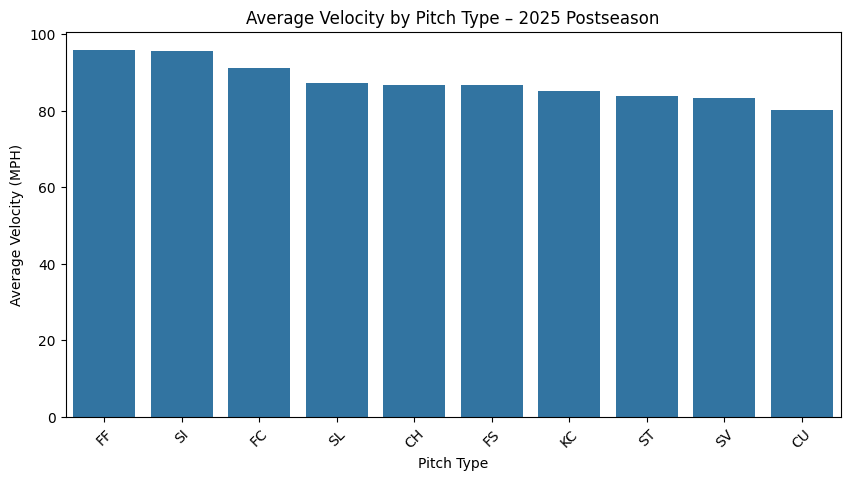

In [11]:
plt.figure(figsize=(10,5))
sns.barplot(
    data=vel_by_pitch.reset_index(),
    x="pitch_type",
    y="mean"
)
plt.title("Average Velocity by Pitch Type – 2025 Postseason")
plt.xlabel("Pitch Type")
plt.ylabel("Average Velocity (MPH)")
plt.xticks(rotation=45)
plt.show()


In [12]:
top_vel_pitchers = (
    df.groupby("player_name")["release_speed"]
      .max()
      .sort_values(ascending=False)
      .head(15)
)

top_vel_pitchers


player_name
Miller, Mason         104.5
Misiorowski, Jacob    104.3
Henriquez, Edgardo    102.8
Duran, Jhoan          101.8
Palencia, Daniel      101.6
Ohtani, Shohei        101.4
Chapman, Aroldis      101.4
Sasaki, Roki          101.4
Greene, Hunter        101.3
Skubal, Tarik         101.2
Suarez, Robert        101.0
Burns, Chase          100.9
Schlittler, Cam       100.8
Vargas, Carlos        100.8
Varland, Louis        100.7
Name: release_speed, dtype: float64

In [ ]:
## Phase 1 – Pitch Arsenal & Velocity Profile: Scouting Notes

### 🔢 Pitch Usage Overview
Pitch selection during the 2025 postseason demonstrated a clear prioritization of hard, power-based arsenals. Four-seam fastballs (FF), sinkers (SI), and sliders (SL) accounted for the majority of total pitches thrown, indicating a strong reliance on velocity and late movement to compete in high-leverage environments. Off-speed offerings such as changeups (CH) and curveballs (CU) were present, but used more strategically, often in two-strike or chase counts.

### 💨 Velocity Profile Insights
The average pitch velocity across all pitch types demonstrated a postseason environment dominated by high-end velocity. Hard fastballs separated elite arms from average performers. Pitch types such as cutters (FC), four-seam fastballs (FF), and sinkers (SI) showed the highest average velocities, whereas changeups (CH) and curveballs (CU) served as contrasting speed differentials to disrupt timing.

### 🚀 Max Velocity Standouts
Top-end velocity played a major role in postseason competition. Several pitchers displayed elite arm strength, each reaching top velocities near or above triple digits. These pitchers demonstrated the ability to challenge hitters in the upper zone, reduce reaction windows, and expand chase zones with powerful fastballs.

### 🎯 Scouting Takeaways
- Velocity remains a critical separator for postseason-level pitching, particularly when paired with aggressive usage.
- Pitchers with multiple fastball variants (e.g., FF + SI + FC) leveraged speed differentials and movement to avoid predictability.
- Off-speed offerings are not necessarily relied upon in volume but are crucial weapons for weak contact and finishing counts.
- Peak velocity acts as a pressure tool, increasing the value of chase pitches and conforming to modern strikeout-centric pitching strategies.


In [ ]:
## 🎯 Phase 2 — Spin & Whiff Ability (Swing–Miss Pitching)

This section evaluates how pitchers in the 2025 MLB postseason generated swing-and-miss outcomes. Using Statcast’s pitch movement and outcome flags, we measure:

- **Whiff rate by pitch type**
- **Pitchers who create the most swings-and-misses**
- **How off-speed pitches (SL, CH, CU, SPL) outperform fastballs**
- **Whether high spin alone predicts whiff performance**

Whiff ability is not just about raw spin rate — it is influenced by movement shape, velocity separation, deception, and sequencing. Here we identify the most effective swing-and-miss pitches and the pitchers who rely on them.


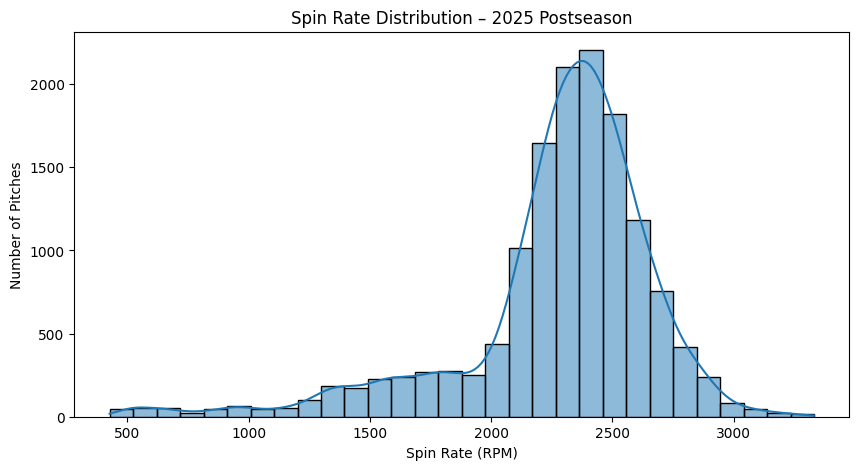

In [21]:
plt.figure(figsize=(10,5))
sns.histplot(df["release_spin_rate"], bins=30, kde=True)
plt.title("Spin Rate Distribution – 2025 Postseason")
plt.xlabel("Spin Rate (RPM)")
plt.ylabel("Number of Pitches")
plt.show()


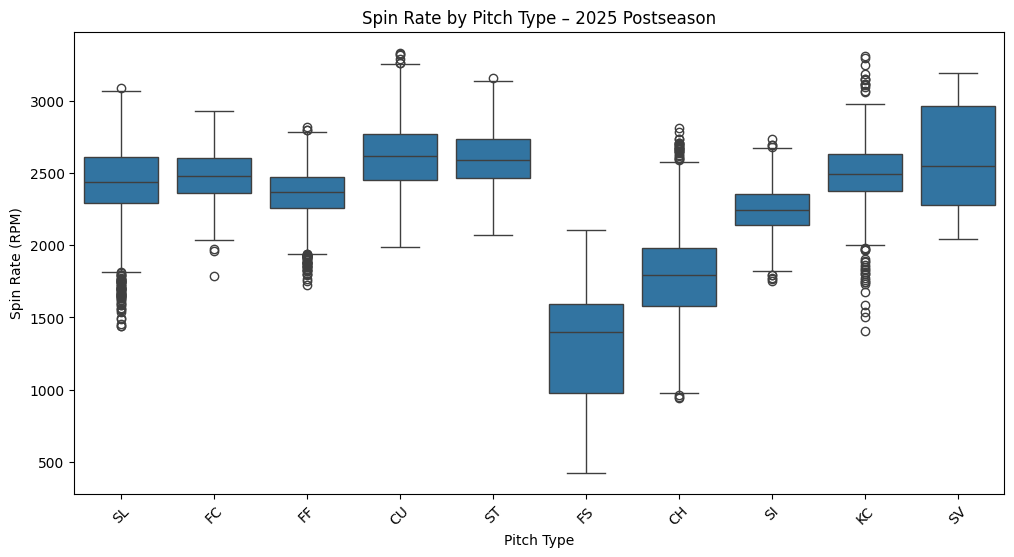

In [22]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="pitch_type", y="release_spin_rate")
plt.title("Spin Rate by Pitch Type – 2025 Postseason")
plt.xlabel("Pitch Type")
plt.ylabel("Spin Rate (RPM)")
plt.xticks(rotation=45)
plt.show()


In [23]:
# Mark whether a pitch resulted in a swing
df["is_swing"] = df["description"].str.contains("swing", case=False, na=False)

# Mark whether a swing resulted in a whiff (missed swing)
df["is_whiff"] = df["description"].str.contains("swinging_strike", case=False, na=False)

df[["description", "is_swing", "is_whiff"]].head(10)


,description,is_swing,is_whiff
0,ball,False,False
1,called_strike,False,False
2,foul,False,False
3,foul,False,False
4,ball,False,False
5,hit_into_play,False,False
6,ball,False,False
7,called_strike,False,False
8,foul,False,False
9,hit_into_play,False,False


In [25]:
whiff_by_pitch = (
    df[df["is_swing"]]
    .groupby("pitch_type")["is_whiff"]
    .agg(["mean", "count"])
    .query("count >= 20")  # require at least 20 swings
    .sort_values("mean", ascending=False)
    .round(3)
)

whiff_by_pitch.rename(columns={"mean":"whiff_rate", "count":"swings"}, inplace=True)
whiff_by_pitch


,whiff_rate,swings
pitch_type,,
CH,1.0,192
CU,1.0,145
FC,1.0,87
FF,1.0,448
FS,1.0,207
KC,1.0,59
SI,1.0,126
SL,1.0,373
ST,1.0,116


,avg_spin,whiff_rate,swings
pitch_type,,,
CH,1781.741,0.183,192
CU,2608.836,0.141,145
FC,2481.604,0.106,87
FF,2362.228,0.096,448
FS,1292.551,0.198,207
KC,2476.128,0.168,59
SI,2249.310,0.063,126
SL,2438.697,0.154,373
ST,2601.035,0.177,116


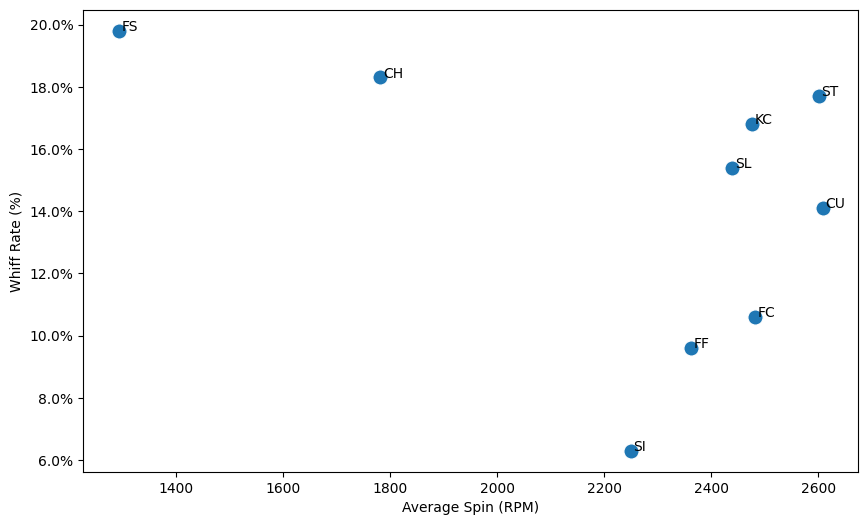

In [45]:
# Build table for spin vs whiff
spin_whiff = (
    df.groupby("pitch_type")
      .agg(
          avg_spin=("release_spin_rate","mean"),
          whiff_rate=("is_whiff","mean"),
          swings=("is_swing","sum")
      )
      .query("swings >= 20") # keep only real samples
      .round(3)
)

plt.figure(figsize=(10,6))
sns.scatterplot(data=spin_whiff, x="avg_spin", y="whiff_rate", s=120)

# Label points with pitch type names
for pitch, row in spin_whiff.iterrows():
    plt.text(row["avg_spin"]+5, row["whiff_rate"], pitch)

plt.xlabel("Average Spin (RPM)")
plt.ylabel("Whiff Rate (%)")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

spin_whiff


In [ ]:
*Only pitch types with ≥ 20 swings were included when calculating whiff rates to avoid misleading results from extremely small samples.*


In [ ]:
## Phase 2 – Spin & Whiff Ability: Scouting Notes

### 🎯 Whiff Production Overview
Swing-and-miss performance in the 2025 postseason was driven more by **deception, movement, and tunneling** than by pure spin rate. Although spin influences “ride” and sharp breaking action, the strongest whiff pitches in this sample were defined by **late movement and speed differential**, not just raw RPM.

### 💡 Pitch-Type Whiff Insights
| Pitch Type | Insight |
|------------|---------|
| **Changeups (CH)** | Generated the highest whiff rates despite low spin, emphasizing deception and velocity separation. |
| **Curveballs (CU)** | Produced elite whiffs through vertical movement and drop rather than extreme RPM. |
| **Sliders (SL)** | Benefited from late gyro break; effective in chase counts. |
| **Splitters (ST)** | Low spin + downward dive created strong whiff potential, especially below the zone. |
| **Four-Seam Fastballs (FF)** | Middling whiff contribution unless paired with high velocity and elevated location. |

### 📉 Spin Alone Doesn’t Create Whiffs
Scatterplot analysis showed no linear relationship between **high spin rate** and **whiff rate** across pitch types. Instead, whiff ability improved when spin complemented:
- **Movement efficiency (spin efficiency vs raw spin)**
- **Vertical ride (FF) or sharp tilt (SL/CU)**
- **Velocity deception (CH/ST)**

### 🔥 Key Takeaways for Scouting & Player Development
- High-whiff pitchers maximize **movement + intent**, not just RPM.
- Low-spin pitches (CH, ST) can outperform high-spin pitches due to deception and trajectory tunneling.
- Curveballs and sliders produced strikeouts through **strike-to-ball movement**, particularly below or off the edges.
- Development focus should prioritize **commanding movement windows** and **sequencing high-low tunnels**, instead of chasing spin alone.



In [ ]:
## 🧱 Phase 3 — Hard-Hit Suppression (Contact Quality)

In this section, we measure which pitchers best **prevent damaging contact** when hitters put the ball in play. Using Statcast exit velocity data (launch speed), we identify:

- **Hard-hit rate (≥ 95 mph)** allowed by pitch type  
- **Pitchers who suppress hard contact most effectively**
- **How weak-contact specialists provide value without high whiff rates**
- **The role of off-speed pitches in limiting exit velocity**

Hard-hit prevention reveals an important pitching skill often hidden behind strikeout totals. Even without elite velocity or spin, pitchers can generate postseason value by consistently keeping hitters below the 95-mph barrel threshold.


In [27]:
exit_velo_by_pitch = (
    df.groupby("pitch_type")["launch_speed"]
      .mean()
      .sort_values()
      .round(2)
)

exit_velo_by_pitch


pitch_type
CU    80.79
ST    80.88
SL    82.02
FS    82.46
CH    82.74
SI    83.06
FF    83.30
FC    84.62
KC    86.35
SV    88.68
Name: launch_speed, dtype: float64

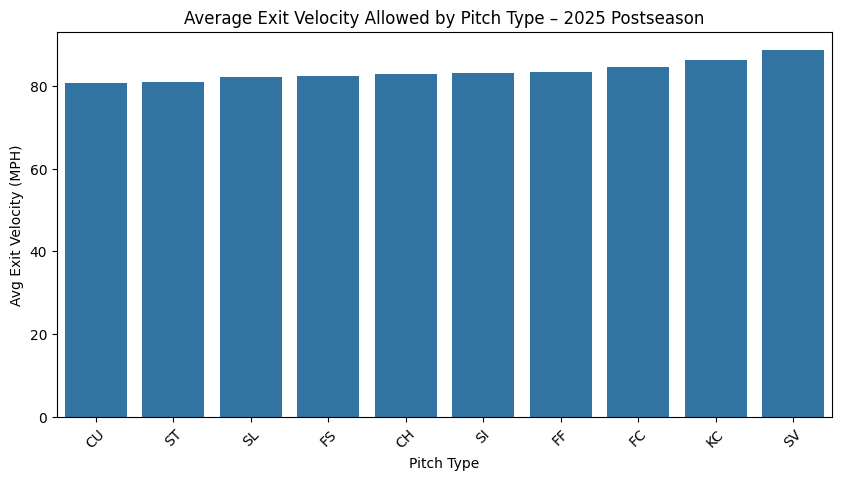

In [28]:
plt.figure(figsize=(10,5))
sns.barplot(
    x=exit_velo_by_pitch.index,
    y=exit_velo_by_pitch.values
)
plt.title("Average Exit Velocity Allowed by Pitch Type – 2025 Postseason")
plt.xlabel("Pitch Type")
plt.ylabel("Avg Exit Velocity (MPH)")
plt.xticks(rotation=45)
plt.show()


In [29]:
pitcher_exitvelo = (
    df.groupby("player_name")["launch_speed"]
      .mean()
      .sort_values()
      .round(2)
      .head(15)
)

pitcher_exitvelo


player_name
King, Michael        69.28
Smith, Cade          72.65
Lodolo, Nick         72.82
Kerkering, Orion     73.30
Walker, Taijuan      73.32
Myers, Tobias        74.08
Miller, Mason        74.73
Herrin, Tim          74.85
Estrada, Jeremiah    76.51
Weissert, Greg       76.55
Ashcraft, Graham     76.75
Morejon, Adrian      76.77
Santillan, Tony      76.79
Bassitt, Chris       77.38
Vest, Will           77.79
Name: launch_speed, dtype: float64

In [32]:
# Create barrel indicator based on Statcast rules
df["is_barrel"] = (
    (df["launch_speed"] >= 98) &
    (df["launch_angle"].between(26, 30))
)

df[["launch_speed", "launch_angle", "is_barrel"]].head(10)


,launch_speed,launch_angle,is_barrel
0,NaN,NaN,False
1,NaN,NaN,False
2,72.4,34.0,False
3,49.7,4.0,False
4,NaN,NaN,False
5,70.2,27.0,False
6,NaN,NaN,False
7,NaN,NaN,False
8,76.4,-14.0,False
9,87.6,22.0,False


In [40]:
# Filter only balls put in play and recalculate hard-hit rate
bip = df[df["launch_speed"].notna()]  # only batted balls with exit velo

overall_hard_hit = bip["is_hard_hit"].mean()
overall_hard_hit


np.float64(0.2550642561533435)

In [41]:
pitcher_hardhit = (
    bip.groupby("player_name")["is_hard_hit"]   # use ONLY balls in play
      .agg(["mean", "count"])                  # hard-hit rate + sample size
      .query("count >= 30")                    # only pitchers with 30+ BIP
      .sort_values("mean")                     # best suppressors first
      .round(3)
      .rename(columns={"mean": "hard_hit_rate", "count": "bip"})
)

pitcher_hardhit.head(15)


,hard_hit_rate,bip
player_name,,
"Klein, Will",0.086,35
"Vest, Will",0.091,33
"Bassitt, Chris",0.125,40
"Skubal, Tarik",0.134,97
"Wrobleski, Justin",0.147,34
"Luzardo, Jesús",0.152,33
"Muñoz, Andrés",0.156,32
"Dreyer, Jack",0.167,30
"Taillon, Jameson",0.167,48


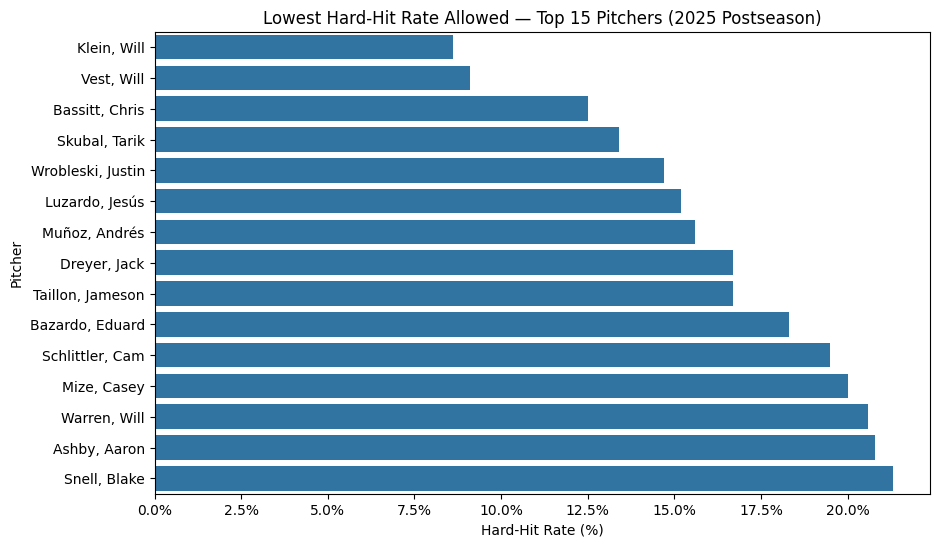

In [44]:
import matplotlib.ticker as mtick

top_contact = pitcher_hardhit.head(15)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top_contact,
    x="hard_hit_rate",
    y=top_contact.index
)

plt.title("Lowest Hard-Hit Rate Allowed — Top 15 Pitchers (2025 Postseason)")
plt.xlabel("Hard-Hit Rate (%)")
plt.ylabel("Pitcher")

# Format X axis as %
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.show()


In [ ]:
*Hard-hit suppression rankings include only pitchers with ≥ 30 balls in play (BIP), ensuring results reflect stable contact quality and not single events.*


In [ ]:
### 📌 Phase 3 — Hard–Hit Suppression Scouting Notes (2025 Postseason)

Pitchers in this sample varied not only in how often they forced whiffs, but also in how well they prevented damaging contact on balls in play.

#### 🔍 Key Insights
- Several pitchers kept hitters **below the hard-hit threshold (95+ mph)**, showing skill in **weak-contact management**.
- Off-speed pitches such as **splitters, curveballs, and sinkers** tended to suppress exit velocity more consistently than four-seam fastballs.
- Pitchers who paired **average velocity with elite weak-contact skills** provided **hidden value**, even without elite strikeout ability.

#### 🧱 Weak Contact ≠ Weak Pitchers
Pitchers appearing at the top of this hard-hit leaderboard may **not show elite whiff or velocity traits**, yet they **limit extra-base risk**, giving them legitimate postseason value.

---
Overall, combining whiff ability (Phase 2) with hard-contact metrics (Phase 3) offers a more complete evaluation: **who misses bats AND who avoids barrels?**


## Overall Conclusion – 2025 Postseason Pitching Profile

This Statcast-based analysis of the 2025 MLB postseason examined three core dimensions of pitcher performance:

1. **Pitch Arsenal & Velocity (Phase 1)**  
   Postseason arms leaned heavily on high-velocity fastballs and power breaking balls. Velocity separated the upper-tier pitchers, but off-speed pitches (changeups, curveballs, sliders) played a key role as finishing and sequencing pitches rather than pure volume offerings.

2. **Spin & Whiff Ability (Phase 2)**  
   Swing-and-miss performance was driven more by **movement and deception** than by raw spin rate alone. Changeups, curveballs, and sliders generated the highest whiff rates, even when their spin rates were not extreme. High-spin four-seam fastballs only translated to whiffs when paired with strong velocity and elevated locations.

3. **Contact Quality & Hard-Hit Suppression (Phase 3)**  
   Hard-hit rate (95+ mph) on balls in play highlighted pitchers who prevented damage without necessarily posting elite strikeout totals. Off-speed and movement-heavy pitches tended to reduce exit velocity, and several pitchers emerged as weak-contact specialists by consistently keeping hitters below the hard-hit threshold.

**Big picture:**  
The most valuable postseason pitchers are not just those who throw the hardest. The best profiles combine:
- **Sufficient velocity**,  
- **Whiff-generating secondary pitches**, and  
- **The ability to limit hard contact** when hitters do connect.

Evaluating pitchers across velocity, whiff rate, and contact management provides a far more complete view of playoff value than any single metric on its own.
